In [138]:
import config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
from mysql.connector import errorcode

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeRegressor
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from IPython.display import Image  
# import pydotplus
from sklearn.metrics import mean_squared_error
import itertools    

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, f1_score, precision_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import GridSearchCV

## Call DB to retrieve data and save to a dataframe

In [ ]:
db_name = config.db_name

In [ ]:
cnx = mysql.connector.connect(
    host=config.host,
    user=config.user,
    passwd=config.password,
    database=db_name,
    buffered=True
)

cursor = cnx.cursor()

In [107]:
execute_statement = """
                    SELECT 
                            d.id, d.pk, d.annual_inc, d.more_than_50k, 
                            d.purpose, d.application_type, d.grade, d.home_ownership,
                            d.addr_state, d.zip_code, d.loan_amnt, d.emp_length,
                            d.tot_hi_cred_lim, d.fico_range_low, d.dti,
                            c.med_inc, c.pk, d.pk
                    FROM 
                            mod5_project.dataset_lendingclub AS d
                    LEFT JOIN 
                            mod5_project.zip_codes AS z
                    ON 
                            d.pk = z.pk1
                    LEFT JOIN 
                            mod5_project.census_median_income_data AS c
                    ON 
                            c.pk = z.pk
                    GROUP BY 
                            d.id
                    ;                    
                    """
cursor.execute(execute_statement)
df = cursor.fetchall()
column = ['id', 'pk', 'annual_inc', 'more_than_50k', 
          'purpose', 'application_type', 'grade', 'home_ownership', 
          'addr_state', 'zip_code', 'loan_amnt', 'emp_length', 
          'tot_hi_cred_lim', 'fico_range_low', 'dti',
          'med_inc_county', 'c.pk', 'z.pk'
         ]
df = pd.DataFrame(df, columns = column)

df = df[[  'id','annual_inc','more_than_50k','purpose',
           'application_type','grade','home_ownership','addr_state',
           'zip_code','loan_amnt','emp_length','tot_hi_cred_lim',
           'fico_range_low','dti', 'med_inc_county']]

df = df.dropna()
df

,id,annual_inc,more_than_50k,purpose,application_type,grade,home_ownership,addr_state,zip_code,loan_amnt,emp_length,tot_hi_cred_lim,fico_range_low,dti,med_inc_county
0,144271390,133250.0,1,debt_consolidation,Joint App,B,MORTGAGE,SC,296xx,35000.0,10.0,213475.0,700.0,10.67,35254.0
1,145219778,54000.0,1,debt_consolidation,Individual,A,OWN,SC,296xx,29000.0,0.0,88666.0,685.0,14.39,35254.0
2,144545077,32000.0,0,credit_card,Joint App,A,OWN,LA,705xx,9000.0,8.0,76269.0,720.0,37.13,40492.0
3,144970474,52000.0,1,debt_consolidation,Individual,C,MORTGAGE,LA,705xx,12000.0,10.0,131063.0,760.0,33.12,40492.0
4,145462395,40000.0,0,credit_card,Individual,A,OWN,LA,705xx,10000.0,4.0,52590.0,725.0,12.60,40492.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103364,149415766,125000.0,1,debt_consolidation,Individual,D,MORTGAGE,CT,062xx,16000.0,1.0,307985.0,675.0,13.87,62553.0
103365,149427201,100936.0,1,home_improvement,Individual,B,MORTGAGE,CT,062xx,23000.0,10.0,51600.0,750.0,4.35,62553.0
103366,149369454,95000.0,1,debt_consolidation,Individual,C,MORTGAGE,AZ,863xx,24000.0,2.0,459104.0,670.0,35.71,48259.0
103367,149415059,33000.0,0,medical,Joint App,B,MORTGAGE,AZ,863xx,4500.0,0.0,356242.0,720.0,55.89,48259.0


Initial count: 103723 rows × 15 columns
There were some rows that did not contain zipcodes from the webscraping and API calls performed

After dropping the NaN's: 84090 rows × 15 columns
A total of 19633 were dropped

### Saving df created to csv for faster calls

In [5]:
filename = 'cleaned_df.csv'
df.to_csv(filename, index=False)

### Load from csv

In [53]:
df = pd.read_csv('cleaned_df.csv')

In [54]:
df.drop(['id','annual_inc','zip_code','addr_state'],axis=1, inplace=True)

In [55]:
df

,more_than_50k,purpose,application_type,grade,home_ownership,loan_amnt,emp_length,tot_hi_cred_lim,fico_range_low,dti,med_inc_county
0,1,debt_consolidation,Joint App,B,MORTGAGE,35000.0,10.0,213475.0,700.0,10.67,35254.0
1,1,debt_consolidation,Individual,A,OWN,29000.0,0.0,88666.0,685.0,14.39,35254.0
2,0,credit_card,Joint App,A,OWN,9000.0,8.0,76269.0,720.0,37.13,40492.0
3,1,debt_consolidation,Individual,C,MORTGAGE,12000.0,10.0,131063.0,760.0,33.12,40492.0
4,0,credit_card,Individual,A,OWN,10000.0,4.0,52590.0,725.0,12.60,40492.0
5,1,debt_consolidation,Individual,B,MORTGAGE,23000.0,10.0,88743.0,710.0,28.36,42260.0
6,1,debt_consolidation,Individual,C,RENT,14000.0,6.0,45001.0,665.0,19.79,42260.0
7,0,other,Individual,C,RENT,5000.0,2.0,69365.0,710.0,39.80,42260.0
8,1,debt_consolidation,Individual,C,RENT,21600.0,4.0,61332.0,690.0,12.40,42260.0
9,0,credit_card,Joint App,C,MORTGAGE,16400.0,3.0,248203.0,695.0,30.60,42260.0


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84090 entries, 0 to 84089
Data columns (total 11 columns):
more_than_50k       84090 non-null int64
purpose             84090 non-null object
application_type    84090 non-null object
grade               84090 non-null object
home_ownership      84090 non-null object
loan_amnt           84090 non-null float64
emp_length          84090 non-null float64
tot_hi_cred_lim     84090 non-null float64
fico_range_low      84090 non-null float64
dti                 84090 non-null float64
med_inc_county      84090 non-null float64
dtypes: float64(6), int64(1), object(4)
memory usage: 7.1+ MB


Target Variable
more_than_50k
0    21373
1    62717
Name: more_than_50k, dtype: int64


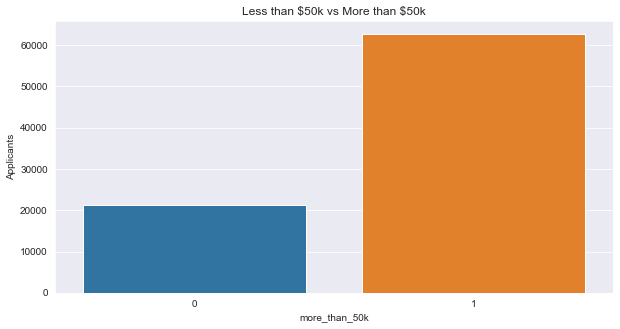

In [57]:
print('Target Variable')
print(df.groupby(['more_than_50k']).more_than_50k.count())

# Target Variable Countplot
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(df['more_than_50k'])
plt.title('Less than \$50k vs More than \$50k')
plt.ylabel('Applicants')
plt.show()

In [58]:
# Baseline = 34%

### Unprocessed data

In [59]:
# Dirty (no categorical, no standardscaling)
X = df.loc[:, 'loan_amnt':'med_inc_county']
y = df['more_than_50k']

### Using StandardScaler() to Standardize features

In [60]:
scale = StandardScaler()
df[['loan_amnt','emp_length','tot_hi_cred_lim',
     'fico_range_low','dti', 'med_inc_county']] = scale.fit_transform(df[['loan_amnt','emp_length','tot_hi_cred_lim',
                         'fico_range_low','dti','med_inc_county']])

In [11]:
df

,more_than_50k,purpose,application_type,grade,home_ownership,loan_amnt,emp_length,tot_hi_cred_lim,fico_range_low,dti,med_inc_county
0,1,debt_consolidation,Joint App,B,MORTGAGE,1.747736,1.165466,0.081957,-0.192733,-0.857260,-1.453094
1,1,debt_consolidation,Individual,A,OWN,1.167005,-1.423624,-0.643157,-0.627188,-0.513762,-1.453094
2,0,credit_card,Joint App,A,OWN,-0.768764,0.647648,-0.715181,0.386540,1.586004,-1.134076
3,1,debt_consolidation,Individual,C,MORTGAGE,-0.478399,1.165466,-0.396839,1.545087,1.215729,-1.134076
4,0,credit_card,Individual,A,OWN,-0.671976,-0.387988,-0.852751,0.531359,-0.679047,-1.134076
5,1,debt_consolidation,Individual,B,MORTGAGE,0.586274,1.165466,-0.642710,0.096904,0.776200,-1.026397
6,1,debt_consolidation,Individual,C,RENT,-0.284822,0.129830,-0.896842,-1.206461,-0.015137,-1.026397
7,0,other,Individual,C,RENT,-1.155918,-0.905806,-0.755292,0.096904,1.832546,-1.026397
8,1,debt_consolidation,Individual,C,RENT,0.450771,-0.387988,-0.801962,-0.482370,-0.697515,-1.026397
9,0,credit_card,Joint App,C,MORTGAGE,-0.052529,-0.646897,0.283720,-0.337551,0.983037,-1.026397


### One-Hot Encoding Categorical Columns 

In [61]:
df = pd.get_dummies(df, drop_first=True)

In [62]:
df

,more_than_50k,loan_amnt,emp_length,tot_hi_cred_lim,fico_range_low,dti,med_inc_county,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,...,application_type_Joint App,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT
0,1,1.747736,1.165466,0.081957,-0.192733,-0.857260,-1.453094,0,1,0,...,1,1,0,0,0,0,0,1,0,0
1,1,1.167005,-1.423624,-0.643157,-0.627188,-0.513762,-1.453094,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,-0.768764,0.647648,-0.715181,0.386540,1.586004,-1.134076,1,0,0,...,1,0,0,0,0,0,0,0,1,0
3,1,-0.478399,1.165466,-0.396839,1.545087,1.215729,-1.134076,0,1,0,...,0,0,1,0,0,0,0,1,0,0
4,0,-0.671976,-0.387988,-0.852751,0.531359,-0.679047,-1.134076,1,0,0,...,0,0,0,0,0,0,0,0,1,0
5,1,0.586274,1.165466,-0.642710,0.096904,0.776200,-1.026397,0,1,0,...,0,1,0,0,0,0,0,1,0,0
6,1,-0.284822,0.129830,-0.896842,-1.206461,-0.015137,-1.026397,0,1,0,...,0,0,1,0,0,0,0,0,0,1
7,0,-1.155918,-0.905806,-0.755292,0.096904,1.832546,-1.026397,0,0,0,...,0,0,1,0,0,0,0,0,0,1
8,1,0.450771,-0.387988,-0.801962,-0.482370,-0.697515,-1.026397,0,1,0,...,0,0,1,0,0,0,0,0,0,1
9,0,-0.052529,-0.646897,0.283720,-0.337551,0.983037,-1.026397,1,0,0,...,1,0,1,0,0,0,0,1,0,0


### Processed Data

In [63]:
X = df.loc[:, 'loan_amnt':'home_ownership_RENT']
y = df['more_than_50k']

In [64]:
y

0        1
1        1
2        0
3        1
4        0
5        1
6        1
7        0
8        1
9        0
10       1
11       1
12       0
13       0
14       1
15       1
16       1
17       0
18       1
19       1
20       1
21       1
22       1
23       1
24       1
25       1
26       0
27       0
28       0
29       1
        ..
84060    1
84061    1
84062    1
84063    1
84064    1
84065    1
84066    1
84067    1
84068    1
84069    1
84070    1
84071    0
84072    1
84073    1
84074    0
84075    0
84076    1
84077    1
84078    1
84079    1
84080    1
84081    1
84082    1
84083    1
84084    0
84085    1
84086    1
84087    1
84088    0
84089    1
Name: more_than_50k, Length: 84090, dtype: int64

In [65]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

In [66]:
dummy_clf = DummyClassifier(strategy="uniform", random_state=1)
dummy_clf.fit(X_train, y_train)
# dummy.predict(X_test)
dummy_clf.score(X_test, y_test)  

0.5008919015340706

### Regression Trees

In [67]:
regTree = DecisionTreeRegressor(max_depth=8)
# fit the tree
regTree.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [68]:
# dot_data = StringIO()
# export_graphviz(regTree, out_file=dot_data,  
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

In [69]:
regPred = regTree.predict(X_test)

In [70]:
mse = mean_squared_error(regPred, y_test)
mse

0.12149278037078427

[-0.1660489511159682, -0.1544051927857487, -0.1423610313325514, -0.13428577911335446, -0.12878592432025146, -0.12478830496892694, -0.1222928727753511, -0.12169867296363886, -0.12261618631773087]


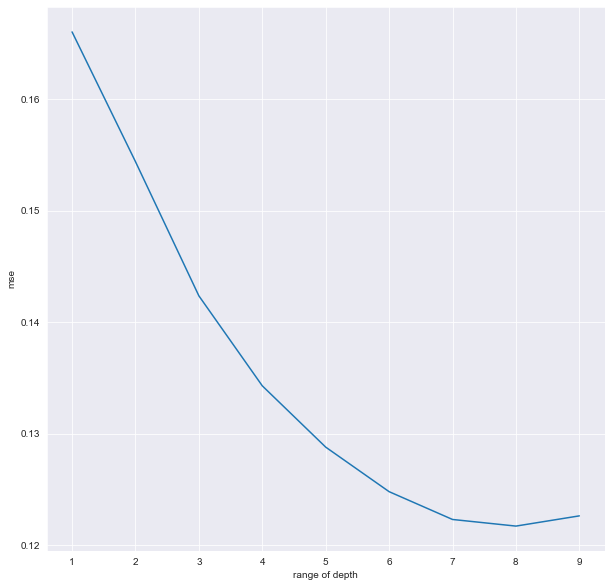

In [71]:
from sklearn.model_selection import cross_val_score
depth_range = range(1,10)
mse = []
for depth in depth_range:
    regtree = DecisionTreeRegressor(max_depth = depth)
    depth_score = cross_val_score(regtree, X, y, scoring = 'neg_mean_squared_error',cv = 6)
    mse.append(depth_score.mean())
print(mse)
mse = [abs(number) for number in mse]
plt.figure(figsize = (10,10))
plt.plot(depth_range, mse)
plt.xlabel('range of depth')
plt.ylabel('mse')
plt.show()

### Decision Trees

In [72]:
from sklearn.tree import DecisionTreeClassifier
ctree=DecisionTreeClassifier(max_depth = 2)
ctree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [73]:
# dot_data = StringIO()
# export_graphviz(ctree, out_file=dot_data,  
#                 rounded=True,
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

In [74]:
clasPred = ctree.predict(X_test)

In [75]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, clasPred)

0.7855868712094185

[0.746997351801123, 0.7883458393825492, 0.8069925657790586, 0.8087644683596996, 0.8178856693421291, 0.8248186557965038, 0.8282316847900089, 0.8296349835102497, 0.8299562038326749, 0.8260079299578859, 0.8239505976786167, 0.818254358011485, 0.813961387374686, 0.8074920836279375]


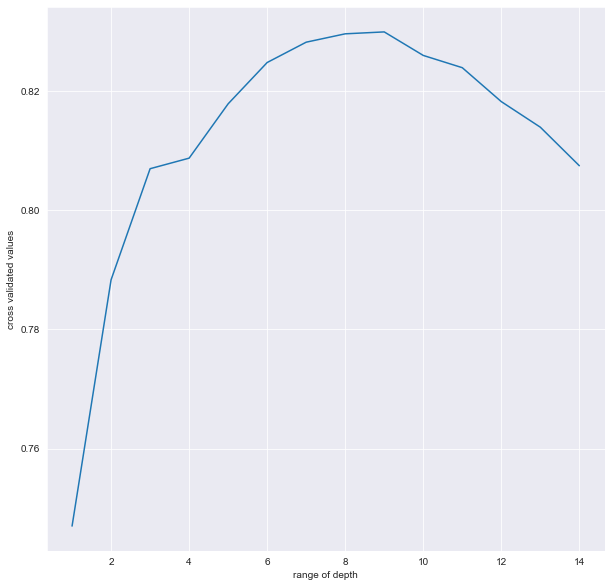

In [76]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(ctree, X, y, cv = 15)
score.mean()
depth_range = range(1,15)
val = []
for depth in depth_range:
    ctree = DecisionTreeClassifier(max_depth = depth)
    depth_score = cross_val_score(ctree, X, y, cv = 15)
    val.append(depth_score.mean())
print(val)
plt.figure(figsize = (10,10))
plt.plot(depth_range, val)
plt.xlabel('range of depth')
plt.ylabel('cross validated values')
plt.show()

### Random Forest
build a regular tree

In [77]:
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=8) 
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [78]:
tree_clf.feature_importances_

array([1.00764046e-01, 9.46627085e-03, 5.43835940e-01, 3.57007631e-02,
       2.71582381e-01, 4.11617967e-03, 0.00000000e+00, 1.99756994e-04,
       4.74933234e-05, 0.00000000e+00, 2.26590774e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.67718736e-04,
       1.69349013e-04, 2.15595178e-02, 1.79307291e-04, 5.82964297e-04,
       5.44375740e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.75206971e-03, 7.85525826e-05, 1.02672239e-03])

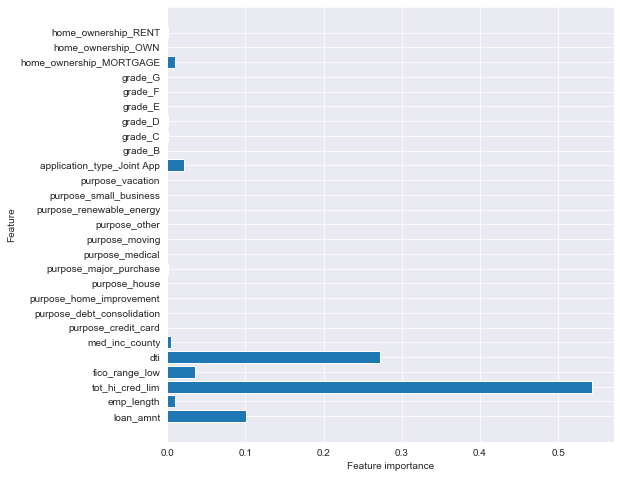

In [79]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(tree_clf)

In [80]:
# Test set predictions
pred = tree_clf.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[ 2182  2144]
 [  712 11780]]
              precision    recall  f1-score   support

           0       0.75      0.50      0.60      4326
           1       0.85      0.94      0.89     12492

    accuracy                           0.83     16818
   macro avg       0.80      0.72      0.75     16818
weighted avg       0.82      0.83      0.82     16818



In [81]:
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, pred) * 100))

Testing Accuracy for Decision Tree Classifier: 83.02%


### Bagged trees

In [82]:
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
                                 n_estimators=20)

In [83]:
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=5,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
       

In [84]:
bagged_tree.score(X_train, y_train)

0.8269711023902961

In [85]:
bagged_tree.score(X_test, y_test)

0.8221548341063146

## Random forests

### Fit a random forests model

In [86]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [87]:
forest.score(X_train, y_train)

0.803261386609585

In [88]:
forest.score(X_test, y_test)

0.8008681174931621

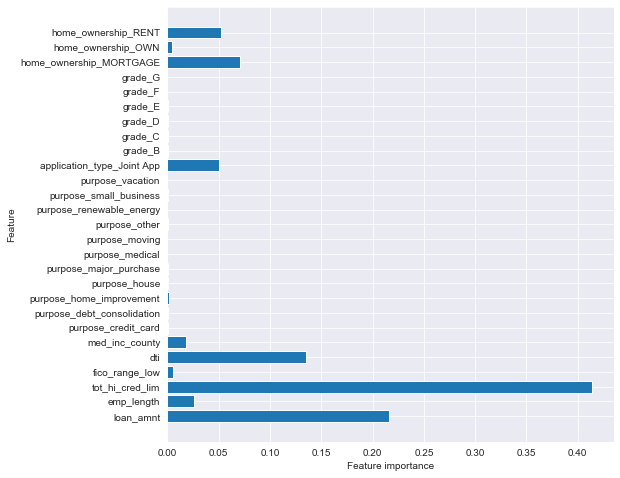

In [89]:
plot_feature_importances(forest)

In [90]:
forest_2 = RandomForestClassifier(n_estimators = 5, max_features= 10, max_depth= 2)
forest_2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [91]:
rf_tree_1 = forest_2.estimators_[0]

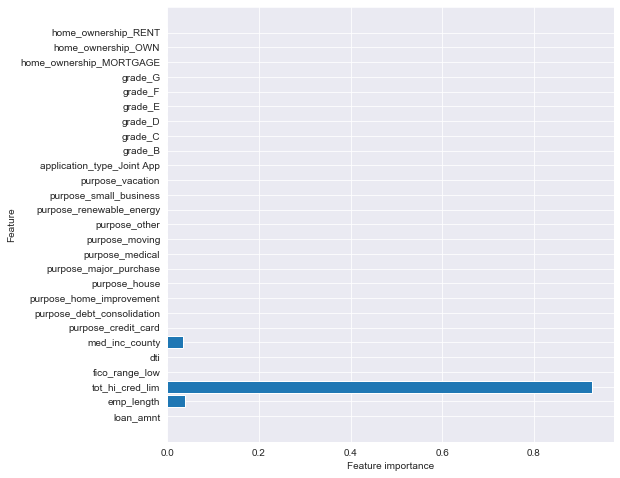

In [92]:
plot_feature_importances(rf_tree_1)

In [93]:
rf_tree_2 = forest_2.estimators_[1]

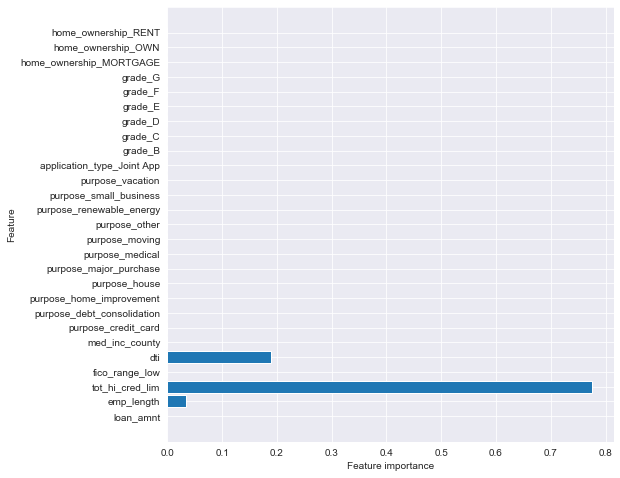

In [94]:
plot_feature_importances(rf_tree_2)

## Logistic Regression

In [95]:
print(y_train.value_counts(),'\n\n', y_test.value_counts())

1    50225
0    17047
Name: more_than_50k, dtype: int64 

 1    12492
0     4326
Name: more_than_50k, dtype: int64


In [98]:
%%time
import numpy as np

def sigmoid(x):
    x = np.array(x)
    return 1/(1 + np.e**(-1*x))

def grad_desc(X, y, max_iterations, alpha, initial_weights=None):
    """Be sure to set default behavior for the initial_weights parameter."""
    if initial_weights is None:
        initial_weights = np.ones((X.shape[1], 1)).flatten()
    weights_col = pd.DataFrame(initial_weights)
    weights = initial_weights
    # Create a for loop of iterations
    for iteration in range(max_iterations):
        # Generate predictions using the current feature weights
        predictions = sigmoid(np.dot(X, weights))
        # Calculate an error vector based on these initial predictions and the correct labels
        error_vector = y - predictions
        # Calculate the gradient 
        # As we saw in the previous lab, calculating the gradient is often the most difficult task.
        # Here, your are provided with the closed form solution for the gradient of the log-loss function derived from MLE
        # For more details on the derivation, see the additional resources section below.
        gradient = np.dot(X.transpose(), error_vector)
        # Update the weight vector take a step of alpha in direction of gradient 
        weights += alpha * gradient
        weights_col = pd.concat([weights_col, pd.DataFrame(weights)], axis=1)
    # Return finalized weights
    return weights, weights_col

weights, weights_col = grad_desc(X_train, y_train, 1500, 0.001)

Wall time: 30.1 s


In [100]:
y_hat_test = sigmoid(np.dot(X_test, weights))
np.round(y_hat_test, 2)

array([0.71, 0.  , 0.  , ..., 1.  , 1.  , 0.  ])

Test AUC: 0.8549868957279215


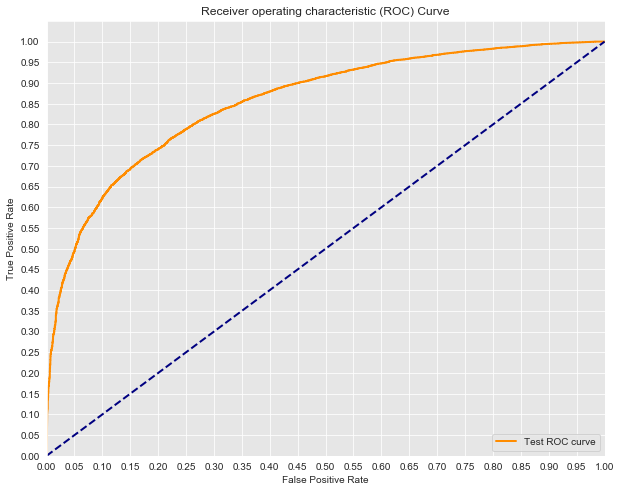

In [101]:
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_hat_test)

print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Train AUC: 0.8502984385131693
Test AUC: 0.8549868957279215


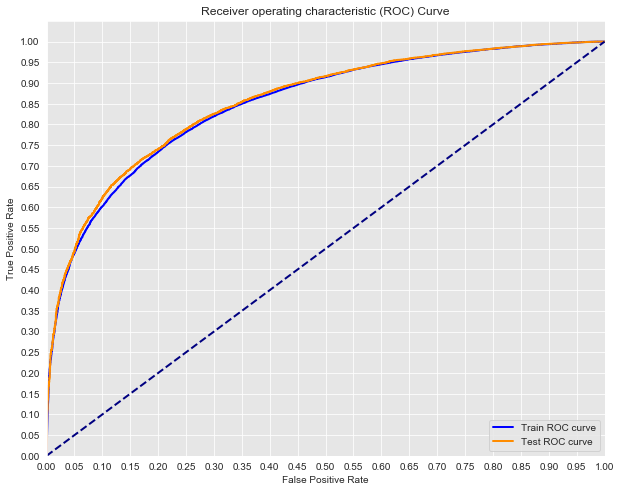

In [102]:
y_hat_train = sigmoid(np.dot(X_train, weights))

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_hat_test)

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_hat_train)

# Train AUC
print('Train AUC: {}'.format(auc(train_fpr, train_tpr)))
print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10,8))
lw = 2

plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Train ROC curve')
plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [103]:
test_predictions = (y_hat_test >= 0.5).astype('int')

cnf_matrix = confusion_matrix(test_predictions, y_test)

print(cnf_matrix)

[[3786 4207]
 [ 540 8285]]


In [104]:
logreg = LogisticRegression(fit_intercept=False, C=1e16, solver='liblinear')
logreg.fit(X_train, y_train)

LogisticRegression(C=1e+16, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Train AUC: 0.8541858299820106
Test AUC: 0.8573219824164118


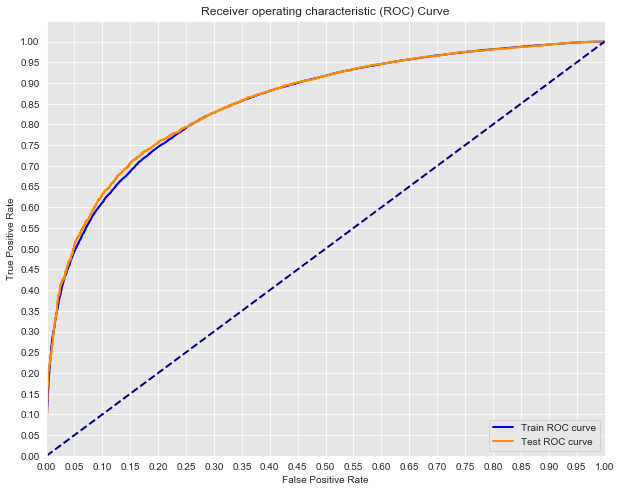

In [105]:
y_train_score = logreg.decision_function(X_train)
y_test_score = logreg.decision_function(X_test)

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)

print('Train AUC: {}'.format(auc(train_fpr, train_tpr)))
print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Train ROC curve')
plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [106]:
logregi = LogisticRegression(fit_intercept=True, C=1e16, solver='liblinear')
logregi.fit(X_train, y_train)

LogisticRegression(C=1e+16, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Custom Model Test AUC: 0.8549868957279215
Custome Model Train AUC: 0.8502984385131693
Scikit-learn Model 1 Test AUC: 0.8573219824164118
Scikit-learn Model 1 Train AUC: 0.8541858299820106
Scikit-learn Model 2 with intercept Test AUC: 0.8589914743771658
Scikit-learn Model 2 with intercept Train AUC: 0.8558056914238481


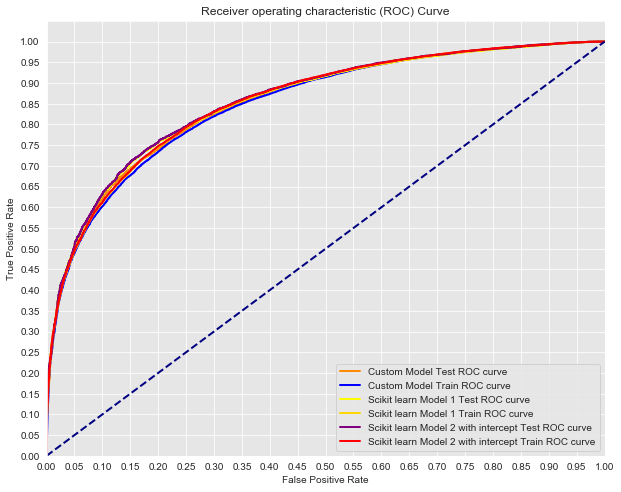

In [107]:
# Initial model plots
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_hat_test)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_hat_train)


print('Custom Model Test AUC: {}'.format(auc(test_fpr, test_tpr)))
print('Custome Model Train AUC: {}'.format(auc(train_fpr, train_tpr)))

plt.figure(figsize=(10,8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Custom Model Test ROC curve')
plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Custom Model Train ROC curve')


# Second model plots
y_test_score = logreg.decision_function(X_test)
y_train_score = logreg.decision_function(X_train)

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)

print('Scikit-learn Model 1 Test AUC: {}'.format(auc(test_fpr, test_tpr)))
print('Scikit-learn Model 1 Train AUC: {}'.format(auc(train_fpr, train_tpr)))


plt.plot(test_fpr, test_tpr, color='yellow',
         lw=lw, label='Scikit learn Model 1 Test ROC curve')
plt.plot(train_fpr, train_tpr, color='gold',
         lw=lw, label='Scikit learn Model 1 Train ROC curve')


# Third model plots
y_test_score = logregi.decision_function(X_test)
y_train_score = logregi.decision_function(X_train)

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)

print('Scikit-learn Model 2 with intercept Test AUC: {}'.format(auc(test_fpr, test_tpr)))
print('Scikit-learn Model 2 with intercept Train AUC: {}'.format(auc(train_fpr, train_tpr)))


plt.plot(test_fpr, test_tpr, color='purple',
         lw=lw, label='Scikit learn Model 2 with intercept Test ROC curve')
plt.plot(train_fpr, train_tpr, color='red',
         lw=lw, label='Scikit learn Model 2 with intercept Train ROC curve')

# Formatting
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

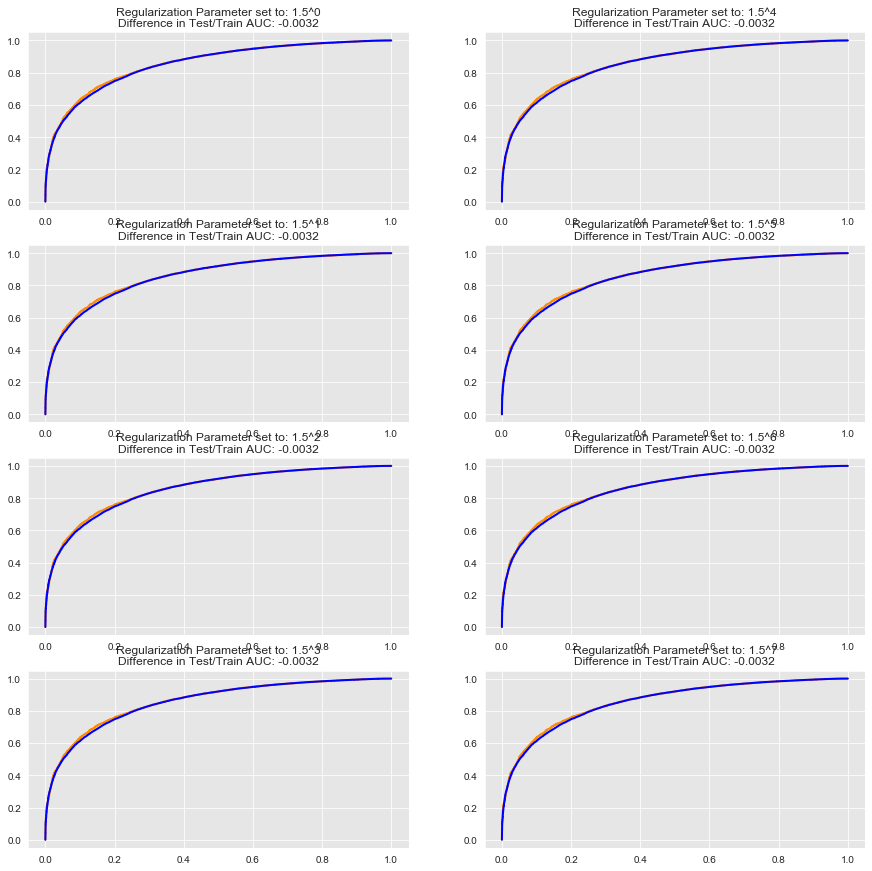

In [108]:
fig, axes = plt.subplots(4,2, figsize=(15, 15))
for n in range(8):
    i = n%4
    j = n//4
    ax = axes[i, j]
    # Fit a model
    logreg = LogisticRegression(fit_intercept=True, C=1.5**(n), solver='liblinear')
    logreg.fit(X_train, y_train)
    
    y_test_score = logreg.decision_function(X_test)
    y_train_score = logreg.decision_function(X_train)

    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)
    
    test_auc = auc(test_fpr, test_tpr)
    train_auc = auc(train_fpr, train_tpr)
    auc_diff = round(train_auc - test_auc, 4)

#     print('Test AUC with C=1.5^{}: {}'.format(n*2, auc(test_fpr, test_tpr)))
#     print('Train AUCwith C=1.5^{}: {}'.format(n*2, auc(train_fpr, train_tpr)))
    # Add the plot
    ax.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')
    ax.plot(train_fpr, train_tpr, color='blue',
             lw=lw, label='Train ROC curve')
    
    ax.set_title('Regularization Parameter set to: 1.5^{}\nDifference in Test/Train AUC: {}'.format(n, auc_diff))

## XGBoost

In [134]:
# Instantiate XGBClassifier
clf = XGBClassifier()

# Fit XGBClassifier
clf.fit(X_train, y_train)

# Predict on training and test sets
training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

# Precision of training and test sets
training_precision = precision_score(y_train, training_preds)
test_precision = precision_score(y_test, test_preds)


print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
print('Training precision: {:.4}%'.format(training_precision * 100))
print('Validation precision: {:.4}%'.format(test_precision * 100))

Training Accuracy: 84.43%
Validation accuracy: 84.34%
Training precision: 85.69%
Validation precision: 85.47%


In [131]:
param_grid = {
    'learning_rate': [0.1],
    'max_depth': [20],
    'min_child_weight': [2],
    'subsample': [0.5],
    'n_estimators': [150],
}

In [132]:
%%time
grid_clf = GridSearchCV(clf, param_grid, scoring='precision', cv=None, n_jobs=-1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
training_precision = precision_score(y_train, training_preds)
test_precision = precision_score(y_test, test_preds)


print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
print('Training Precision: {:.4}%'.format(training_precision * 100))
print('Validation Precision: {:.4}%'.format(test_precision * 100))

C:\Users\Kenny\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 20
min_child_weight: 2
n_estimators: 150
subsample: 0.5

Training Accuracy: 98.76%
Validation accuracy: 83.48%
Training Precision: 98.64%
Validation Precision: 86.28%
Wall time: 1min 1s


[[ 2306  2020]
 [  613 11879]]


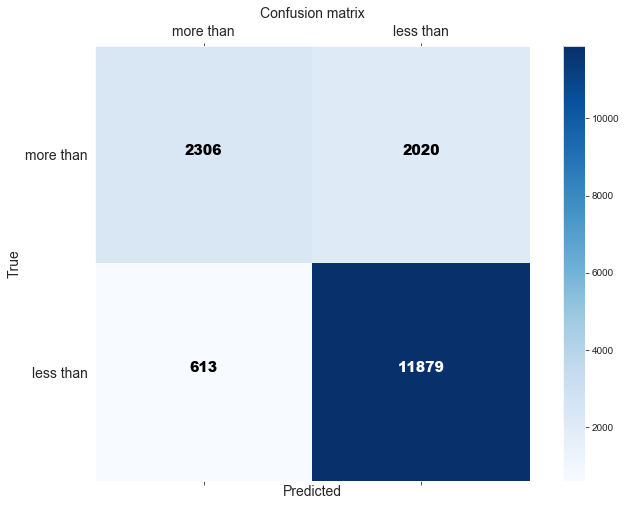

In [140]:
cm = confusion_matrix(y_test, test_preds)
classes = ['more than','less than']
print(cm)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
cax = ax.matshow(cm,cmap=plt.cm.Blues)
plt.title('Confusion matrix',fontdict={'size':14})
fig.colorbar(cax)
ax.set_xticklabels([''] + classes,fontdict={'size':14})
ax.set_yticklabels([''] + classes,fontdict={'size':14})
plt.xlabel('Predicted',fontdict={'size':14})
plt.ylabel('True',fontdict={'size':14})
plt.grid(b=None)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             fontdict={'size':14,'weight':'heavy'},
             color="white" if cm[i, j] > thresh else "black")
plt.show()


## Gradient Boost

In [95]:
# Instantiate an AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(random_state=1)

# Instantiate an GradientBoostingClassifier
gbt_clf = GradientBoostingClassifier(random_state=1)

In [96]:
adaboost_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1)

In [97]:
gbt_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [98]:
# AdaBoost model predictions
adaboost_train_preds = adaboost_clf.predict(X_train)
adaboost_test_preds = adaboost_clf.predict(X_test)

# GradientBoosting model predictions
gbt_clf_train_preds = gbt_clf.predict(X_train)
gbt_clf_test_preds = gbt_clf.predict(X_test)

In [101]:
def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    
print("Training Metrics")
display_acc_and_f1_score(y_train, adaboost_train_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_train, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
print("")
print("Testing Metrics")
display_acc_and_f1_score(y_test, adaboost_test_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_test, gbt_clf_test_preds, model_name='Gradient Boosted Trees')

Training Metrics
Model: AdaBoost
Accuracy: 0.8266738018789392
F1-Score: 0.8879255656587016

Model: Gradient Boosted Trees
Accuracy: 0.8443631823046736
F1-Score: 0.9010097572044474

Testing Metrics
Model: AdaBoost
Accuracy: 0.822511594719943
F1-Score: 0.8846020025515134

Model: Gradient Boosted Trees
Accuracy: 0.8425496491853967
F1-Score: 0.8996133141254077


In [102]:
adaboost_confusion_matrix = confusion_matrix(y_test, adaboost_test_preds)
adaboost_confusion_matrix

array([[ 2392,  1934],
       [ 1051, 11441]])

In [103]:
gbt_confusion_matrix = confusion_matrix(y_test, gbt_clf_test_preds)
gbt_confusion_matrix

array([[ 2305,  2021],
       [  627, 11865]])

In [104]:
adaboost_classification_report = classification_report(y_test, adaboost_test_preds)
print(adaboost_classification_report)

              precision    recall  f1-score   support

           0       0.69      0.55      0.62      4326
           1       0.86      0.92      0.88     12492

    accuracy                           0.82     16818
   macro avg       0.78      0.73      0.75     16818
weighted avg       0.81      0.82      0.82     16818



In [105]:
gbt_classification_report = classification_report(y_test, gbt_clf_test_preds)
print(gbt_classification_report)

              precision    recall  f1-score   support

           0       0.79      0.53      0.64      4326
           1       0.85      0.95      0.90     12492

    accuracy                           0.84     16818
   macro avg       0.82      0.74      0.77     16818
weighted avg       0.84      0.84      0.83     16818



In [108]:
print('Mean Adaboost Cross-Val Score (k=5):')
print(cross_val_score(adaboost_clf, X, y, cv=5).mean())

Mean Adaboost Cross-Val Score (k=5):
0.8244975856817828


In [109]:
print('Mean GBT Cross-Val Score (k=5):')
print(cross_val_score(gbt_clf, X, y, cv=5).mean())

Mean GBT Cross-Val Score (k=5):
0.8413486628582006


## Adaboost

In [ ]:
# Instantiate AdaBoostClassifier
clf_ada = AdaBoostClassifier()

# Fit AdaBoostClassifier
clf_ada.fit(X_train, y_train)

# Predict on training and test sets
training_preds = clf_ada.predict(X_train)
test_preds = cclf_adalf.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

## Gridsearch

create baseline model: Decision Trees

In [111]:
dt_clf = DecisionTreeClassifier()

dt_cv_score = cross_val_score(dt_clf, X_train, y_train, cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score: 77.02%


In [112]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [113]:
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                

In [114]:
# Mean training score
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])

# Mean test score
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 83.12%
Mean Test Score: 82.33%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 5,
 'min_samples_split': 10}

In [116]:
rf_clf = RandomForestClassifier()
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, X_train, y_train, cv=3))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")

/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Mean Cross Validation Score for Random Forest Classifier: 81.72%


In [117]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [118]:
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Training Accuracy: 83.86%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 100}


In [ ]:
--- decision trees
--- random forests
--- logistic regression
--- xgboost
--- adaboost
--- gradient boost
svm

implement whenever (for pipelines)

confusion matrix
scores for precision accuracy recall
F1 scores
AUC ROC

more important is precision over accuracy because we care about ppl able to pay loans

accuracy will have a lot of false positives
precision (bottom left is what is most important)